<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Creation_of_new_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New database
This file is meant to create a new database with:
- Vessels 63x63
- Vessels 63x63+offset
- Green Channel

In [1]:
!rm -rf *
!nvidia-smi

Tue Oct 27 21:20:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from IPython.display import clear_output
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ESQgnFayDEZHtMe3MEvtOxYBj_FMmJhAzjyTM8RxF9m65w?download=1"
!mv "ESQgnFayDEZHtMe3MEvtOxYBj_FMmJhAzjyTM8RxF9m65w?download=1" Drive_histogram_modification.zip
!unzip Drive_histogram_modification.zip
!rm Drive_histogram_modification.zip
clear_output()
print("Drive_histogram_modification.zip Downloaded")

Drive_histogram_modification.zip Downloaded


In [3]:
!mkdir ./DRIVE_histogram_variations/images_vessels_extracted

In [4]:
!git clone --depth 1 https://github.com/Vengadore/Segmentation_OPTOS.git

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [1]:
import os
import cv2
import torch
from Segmentation_OPTOS.Tools.Generators.Patch_generator import Image2Generator,Generator2ImagePT
from autoencoder import *
import numpy as np

In [2]:
# Load model
model = torch.load('Modelo_seg_BEST.ph')

In [3]:
# Files
path_original = "./DRIVE_histogram_variations/images"
Original_files = [os.path.join(path_original,file) for file in os.listdir(path_original) if ".tif" in file]

new_path = "./DRIVE_histogram_variations/images_vessels_extracted"

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(Original_files,ncols = 100)

for file in progress_bar:
    ###### Load image
    I = cv2.imread(file)
    
    ###### Resize image
    (M,N,C) = I.shape
    I = cv2.resize(I,(int(N/M*584*4), 584*4),cv2.INTER_CUBIC)
    
    ###### Compute mask?
    
    ###### Create generators
    #--First Generator 63x63--
    I1_generator = Image2Generator(I,patch_size=[63,63],batch_size=1)
    I1 = Generator2ImagePT(model,I1_generator)
    
    #--Second generator 63x63 + offset--
    scale_percent = 110 # percent of original size
    width = int(I.shape[1] * scale_percent / 100)
    height = int(I.shape[0] * scale_percent / 100)
    dim = (width, height) 
    Image2 = 0*cv2.resize(I, dim) 
    Image2[32:I1_generator.M+32,32:I1_generator.N+32,:] = I
    I2_generator = Image2Generator(Image2,patch_size=[63,63],batch_size=1)
    I2 = Generator2ImagePT(model,I2_generator)
    I2 = I2[32:I1_generator.M+32,32:I1_generator.N+32]
    
    ###### Normalize all channels between 0 and 1
    norm = lambda x : cv2.normalize(x, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ChannelB = norm(I1)
    ChannelG = norm(I[:,:,1])
    ChannelR = norm(I2)
    
    ###### Use --I1-- and --I2-- as two channels for the new image
    ChannelB = np.expand_dims(ChannelB,axis = -1)
    ChannelG = np.expand_dims(ChannelG,axis = -1)
    ChannelR = np.expand_dims(ChannelR,axis = -1)
    
    ###### Append them to a single image
    Final_I = np.concatenate((np.concatenate((ChannelB,ChannelG),axis = -1),ChannelR),axis = -1)
    
    ###### Resize Image
    Final_I = cv2.resize(Final_I,(N,M),cv2.INTER_CUBIC)
    
    ###### Create Uint8 image
    #Final_I = cv2.CV_8U(255*Final_I)
    
    ###### Save new image
    A = cv2.imwrite(os.path.join(new_path,file.split('/')[-1]),Final_I)
    #break

  0%|                                                                       | 0/600 [00:00<?, ?it/s]

In [ ]:
###### Save new image
A = cv2.imwrite("Example.tif",Final_I)

In [ ]:
os.path.join(new_path,file.split('/')[-1])

'/media/DATABASES/CesarCarrillo/DATA BASES/DRIVE_histogram_variations/images/images_vessels_extracted/0000_image.tif'

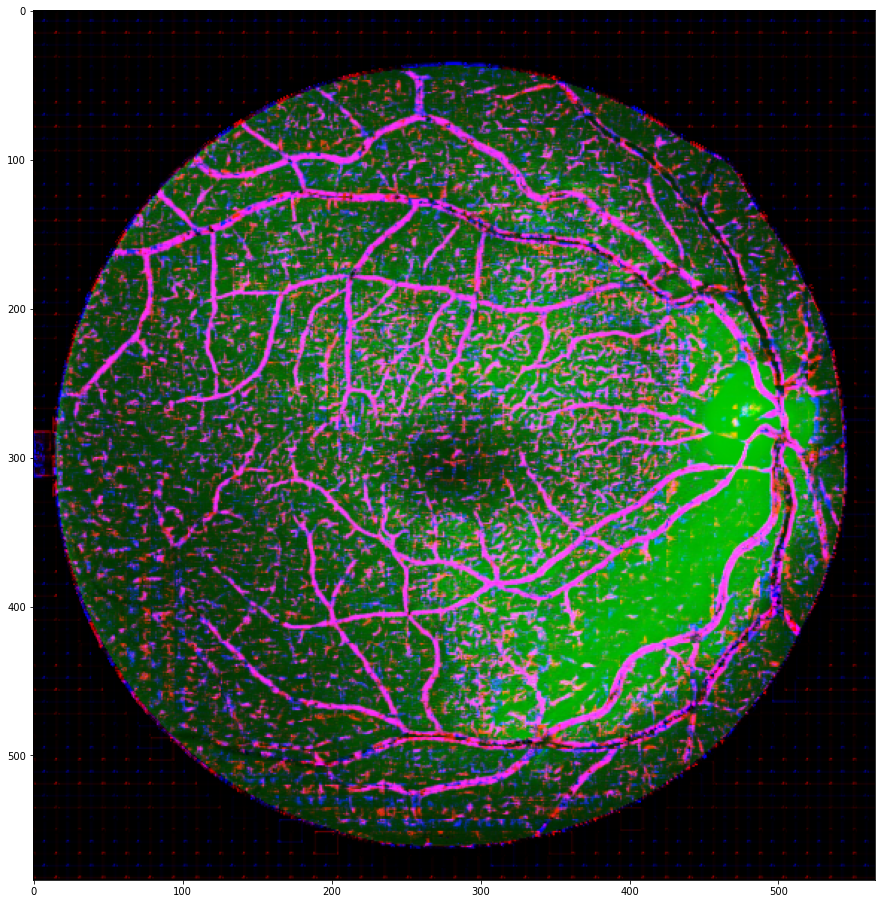

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,16))
plt.imshow(Final_I)

In [ ]:
A

True